## Mapping out YES cases

In [1]:
import pandas as pd
from pathlib import Path

# Define the file path
file_path = Path("/scratch/mch/fackerma/orders/Extracted_metainfo.pkl")

# Load the pickle file into a DataFrame
try:
    df_gust = pd.read_pickle(file_path)
    print("Successfully loaded the DataFrame:")
    print(df_gust.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded the DataFrame:
                                            geometry           traj_ID  \
0  POLYGON ((6.1687 46.4897, 6.1559 46.4806, 6.14...  2022062519100029   
1  POLYGON ((8.4531 47.4548, 8.4397 47.446, 8.439...  2022050516000055   
2  POLYGON ((6.0054 46.2628, 6.0056 46.2538, 5.99...  2022070410050024   
3  POLYGON ((7.3664 46.9735, 7.3664 46.9196, 7.40...  2022050313050051   
4  POLYGON ((8.8371 47.4328, 8.8366 47.4149, 8.84...  2022062318150164   

   yyyymmddHHMM     lon      lat  ell_L ell_S ell_or area  vel_x  ...  \
0  202206251920  6.2212  46.4043  10.30  7.65  126.7  157  27.57  ...   
1  202205051640  8.5275  47.3747  12.91  4.40  115.6   88  -6.12  ...   
2  202207041100  6.0683  46.2261  10.39  3.69   83.2   76  24.03  ...   
3  202205031310  7.4212  46.9308   5.57  3.57  113.9   40  -1.43  ...   
4  202206231900  8.8993  47.3325  12.53  7.80   87.2  174   6.35  ...   

  nrPOHthr080 nrPOHthr090 nrPOHthr100                 chx                 chy  \


In [1]:
na_count = df_gust['time'].isna().sum()
print(na_count)

NameError: name 'df_gust' is not defined

In [2]:
import folium
import pandas as pd
from collections import defaultdict

# Convert coordinates to numeric and clean data
df_gust['lat'] = pd.to_numeric(df_gust['lat'], errors='coerce')
df_gust['lon'] = pd.to_numeric(df_gust['lon'], errors='coerce')
df_gust = df_gust.dropna(subset=['lat', 'lon'])

# Create a map centered on Switzerland
switzerland_map = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Dictionary to store trajectory points
trajectories = defaultdict(list)

# Function to determine color
def get_color(row):
    markers = [
        row.get('STA Marker', 0),
        row.get('ESWD Marker', 0),
        row.get('CS Marker', 0)
    ]
    non_zero = sum(1 for m in markers if m != 0)
    
    if non_zero >= 2:
        return 'black'
    elif markers[2] != 0:  # CS Marker
        return 'red'
    elif markers[1] != 0:  # ESWD Marker
        return 'yellow'
    elif markers[0] != 0:  # STA Marker
        return 'blue'
    else:
        return 'green'

# Add markers and collect trajectory points
for idx, row in df_gust.iterrows():
    try:
        lat = float(row['lat'])
        lon = float(row['lon'])
    except (ValueError, TypeError):
        continue  # Skip invalid coordinates
    
    # Add gust flag filter here
    if row['Gust_Flag'] != 'Yes':
        continue
    
    color = get_color(row)
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"Lat: {lat:.4f}, Lon: {lon:.4f}<br>traj_ID: {row['traj_ID']}",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(switzerland_map)
    
    trajectories[row['traj_ID']].append((lat, lon))

switzerland_map


## Merge 5min files to yearly files

In [5]:
# Dont need this anymore
import os
import pandas as pd
from datetime import datetime

path = "/scratch/mch/fackerma/orders/TRT_processing_3/2023/"
if not os.path.exists(path):
    raise FileNotFoundError(f"Directory {path} not found")

# Updated filename parsing
files = sorted(
    [f for f in os.listdir(path) if f.endswith('.pkl') and f.startswith('TRT_2023')],
    key=lambda x: datetime.strptime(x[4:19], "%Y-%m-%d_%H%M")  # Fixed slice indices
)

dfs = []
for file in files:
    try:
        file_path = os.path.join(path, file)
        df = pd.read_pickle(file_path)
        # Add filename timestamp as column
        df['time'] = datetime.strptime(file[4:19], "%Y-%m-%d_%H%M")
        dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

merged_df = pd.concat(dfs, axis=0, ignore_index=True, join='outer')
merged_df.sort_values('time', inplace=True)

# Save with protocol 5 for large files
merged_df.to_pickle(
    "/scratch/mch/fackerma/orders/TRT_processing_3/TRT_2023_05-10.pkl",
    protocol=5
)


/tmp/ipykernel_6410/3741398973.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dfs, axis=0, ignore_index=True, join='outer')


In [6]:
import os
import pandas as pd
import numpy as np

# Define the input files and output file
base_dir = "/scratch/mch/fackerma/orders/TRT_processing_3/"
input_files = [
    "TRT_2019_05-10.pkl",
    "TRT_2020_05-10.pkl",
    "TRT_2021_05-10.pkl",
    "TRT_2022_05-10.pkl",
    "TRT_2023_05-10.pkl",
]
output_file = "TRT_2019-2023.pkl"

# Full paths for input and output files
input_paths = [os.path.join(base_dir, file) for file in input_files]
output_path = os.path.join(base_dir, output_file)

# Load all input files
dfs = []
all_columns = set()
for file_path in input_paths:
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        df = pd.read_pickle(file_path)
        dfs.append(df)
        all_columns.update(df.columns)
    else:
        print(f"⚠️ File not found: {file_path}")

# Merge all dataframes into one, filling missing columns with NA
if dfs:
    print("Merging dataframes...")
    for i, df in enumerate(dfs):
        missing_cols = all_columns - set(df.columns)
        for col in missing_cols:
            df[col] = np.nan
        dfs[i] = df[sorted(all_columns)]  # Ensure consistent column order

    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    # Sort by 'time' column if it exists, otherwise by the first column
    if 'time' in merged_df.columns:
        merged_df.sort_values("time", inplace=True)
    else:
        print("⚠️ 'time' column not found. Sorting by the first column.")
        merged_df.sort_values(merged_df.columns[0], inplace=True)

    # Save the merged dataframe to a .pkl file
    print(f"Saving merged dataframe to {output_path}...")
    merged_df.to_pickle(output_path, protocol=5)
    print(f"✅ Merge complete! Total rows: {len(merged_df)}, Total columns: {len(merged_df.columns)}")
else:
    print("⛔ No valid files to merge!")


Loading /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2019_05-10.pkl...
Loading /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2020_05-10.pkl...
Loading /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2021_05-10.pkl...
Loading /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2022_05-10.pkl...
Loading /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2023_05-10.pkl...
Merging dataframes...


/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


Saving merged dataframe to /scratch/mch/fackerma/orders/TRT_processing_3/TRT_2019-2023.pkl...
✅ Merge complete! Total rows: 2240266, Total columns: 92


## Perform Statistical Analyzes

In [2]:
# Dont need this
import os
import pandas as pd

# Define the base directory and file names
base_dir = "/scratch/mch/fackerma/orders/TRT_processing_3/"
yearly_files = [
    "TRT_2019_05-10.pkl",
    "TRT_2020_05-10.pkl",
    "TRT_2021_05-10.pkl",
    "TRT_2022_05-10.pkl",
    "TRT_2023_05-10.pkl",
]

# Load each file and print statistics
for file_name in yearly_files:
    file_path = os.path.join(base_dir, file_name)
    
    if os.path.exists(file_path):
        print(f"\nLoading {file_name}...")
        try:
            df = pd.read_pickle(file_path)
            
            # General statistics
            print(f"Number of rows: {len(df)}")
            print(f"Number of columns: {len(df.columns)}")
            print(f"Memory usage: {df.memory_usage().sum() / 1e6:.2f} MB")
            
            # Time range (if 'time' column exists)
            if 'time' in df.columns:
                print(f"Time range: {df['time'].min()} to {df['time'].max()}")
            
            # Column information
            print("Columns:")
            for col in df.columns:
                dtype = df[col].dtype
                non_null = df[col].count()
                null_percentage = (1 - non_null / len(df)) * 100
                print(f"  {col}: {dtype}, {non_null} non-null values ({null_percentage:.2f}% null)")
        except Exception as e:
            print(f"⚠️ Error loading {file_name}: {str(e)}")
    else:
        print(f"⚠️ File not found: {file_name}")

print("\n✅ All files processed!")



Loading TRT_2019_05-10.pkl...
Number of rows: 387960
Number of columns: 37
Memory usage: 117.94 MB
Time range: 2019-05-01 09:55:00 to 2019-10-31 17:30:00
Columns:
  geometry: geometry, 387960 non-null values (0.00% null)
  Age: float64, 387960 non-null values (0.00% null)
  CS Marker: object, 387960 non-null values (0.00% null)
  STA Marker: object, 387960 non-null values (0.00% null)
  ESWD Marker: object, 387960 non-null values (0.00% null)
  STA Speed: object, 119 non-null values (99.97% null)
  Gust_Flag: object, 387960 non-null values (0.00% null)
  time: datetime64[us], 387960 non-null values (0.00% null)
  traj_ID: object, 387960 non-null values (0.00% null)
  yyyymmddHHMM: object, 387960 non-null values (0.00% null)
  lon: float64, 387960 non-null values (0.00% null)
  lat: float64, 387960 non-null values (0.00% null)
  ell_L: float64, 387960 non-null values (0.00% null)
  ell_S: float64, 387960 non-null values (0.00% null)
  ell_or: float64, 387960 non-null values (0.00% null

In [1]:
# Import the data
import os
import pandas as pd
import numpy as np

# Define the base directory and file names
base_dir = "/scratch/mch/fackerma/orders/TRT_processing_3/"
yearly_files = [
    "TRT_2019_05-10.pkl",
    "TRT_2020_05-10.pkl",
    "TRT_2021_05-10.pkl",
    "TRT_2022_05-10.pkl",
    "TRT_2023_05-10.pkl",
]

# Load and merge dataframes
dfs = []
for file_name in yearly_files:
    file_path = os.path.join(base_dir, file_name)
    if os.path.exists(file_path):
        print(f"Loading {file_name}...")
        df = pd.read_pickle(file_path)
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file_name}")

if not dfs:
    print("No data loaded. Exiting.")
    exit()

merged_df = pd.concat(dfs, ignore_index=True)
print(f"\nMerged dataframe shape: {merged_df.shape}")

# Analyze 'Gust_Flag' column
if 'Gust_Flag' in merged_df.columns:
    gust_stats = merged_df['Gust_Flag'].value_counts(normalize=True)
    print("\nGust_Flag distribution:")
    print(gust_stats)


else:
    print("⚠️ 'Gust_Flag' column not found in the merged dataframe.")

print("\n✅ Analysis complete!")


Loading TRT_2019_05-10.pkl...
Loading TRT_2020_05-10.pkl...
Loading TRT_2021_05-10.pkl...
Loading TRT_2022_05-10.pkl...
Loading TRT_2023_05-10.pkl...


/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))



Merged dataframe shape: (2240266, 92)

Gust_Flag distribution:
Gust_Flag
-      0.996580
No     0.002439
Yes    0.000981
Name: proportion, dtype: float64

✅ Analysis complete!


In [4]:
import folium
import pandas as pd
from collections import defaultdict


# Convert coordinates to numeric and clean data
merged_df['lat'] = pd.to_numeric(merged_df['lat'], errors='coerce')
merged_df['lon'] = pd.to_numeric(merged_df['lon'], errors='coerce')
merged_df = merged_df.dropna(subset=['lat', 'lon'])

# Create a map centered on Switzerland
switzerland_map = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Dictionary to store trajectory points
trajectories = defaultdict(list)

# Function to determine color
def get_color(row):
    markers = [
        row.get('STA Marker', 0),
        row.get('ESWD Marker', 0),
        row.get('CS Marker', 0)
    ]
    non_zero = sum(1 for m in markers if m != 0)
    
    if non_zero >= 2:
        return 'black'
    elif markers[2] != 0:  # CS Marker
        return 'red'
    elif markers[1] != 0:  # ESWD Marker
        return 'yellow'
    elif markers[0] != 0:  # STA Marker
        return 'blue'
    else:
        return 'green'

# Add markers and collect trajectory points
for idx, row in merged_df.iterrows():
    try:
        lat = float(row['lat'])
        lon = float(row['lon'])
    except (ValueError, TypeError):
        continue  # Skip invalid coordinates
    
    # Add gust flag filter here
    if row['Gust_Flag'] != 'Yes':
        continue
    
    color = get_color(row)
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"Lat: {lat:.4f}, Lon: {lon:.4f}<br>traj_ID: {row['traj_ID']}",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(switzerland_map)
    
    trajectories[row['traj_ID']].append((lat, lon))

switzerland_map


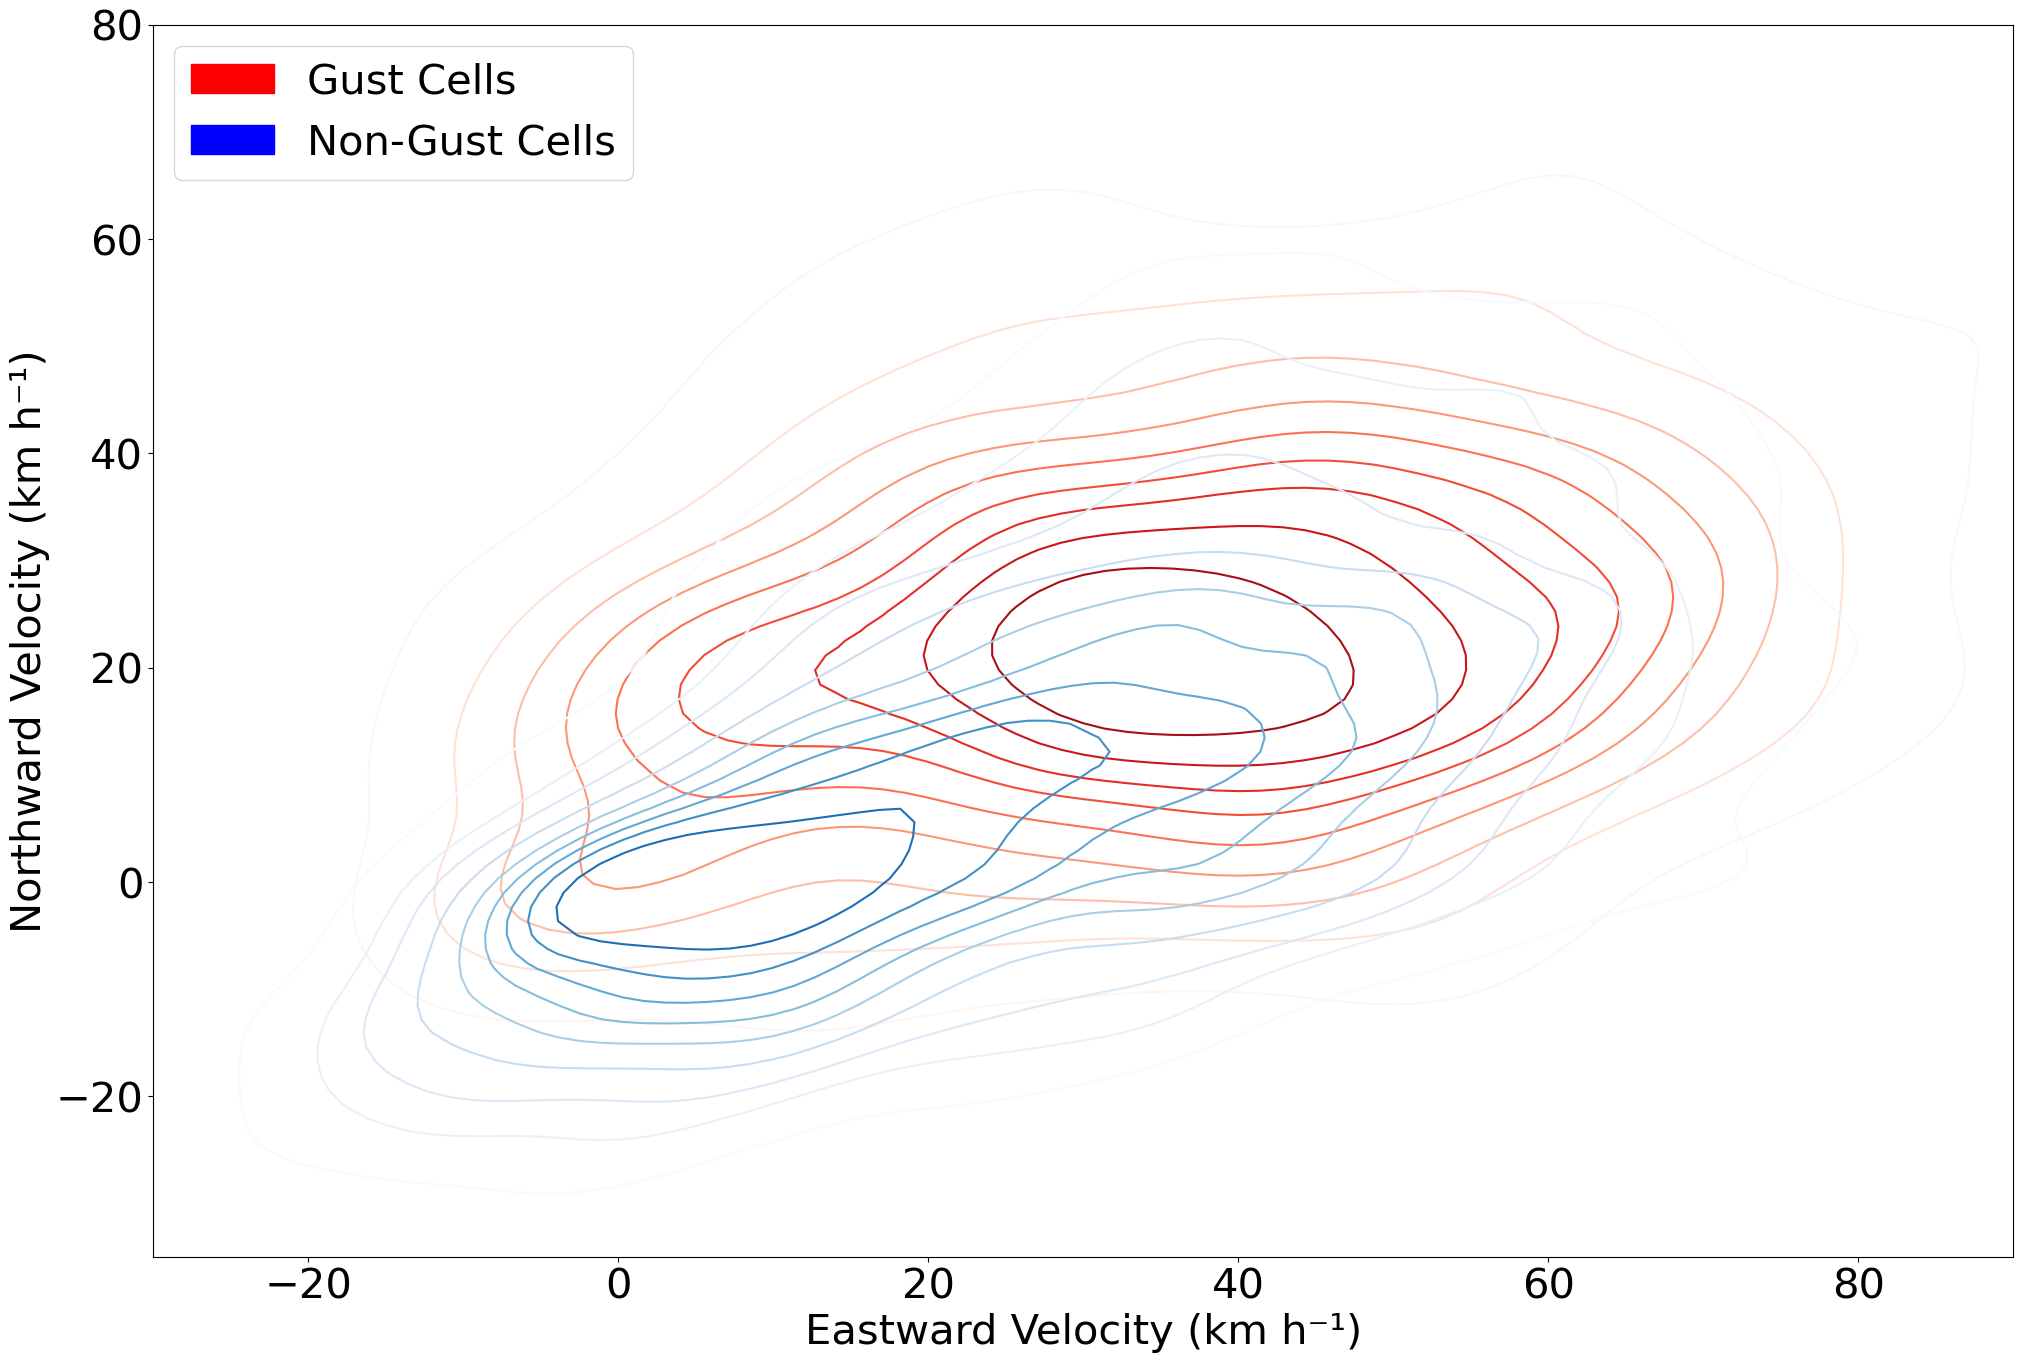

In [ ]:
# Plot Speed Density
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set the default font size for all text elements
plt.rcParams.update({'font.size': 30})

fig, ax = plt.subplots(figsize=(24, 16))

merged_df['vel_x'] = pd.to_numeric(merged_df['vel_x'], errors='coerce')
merged_df['vel_y'] = pd.to_numeric(merged_df['vel_y'], errors='coerce')

clean_df = merged_df.dropna(subset=['vel_x', 'vel_y', 'Gust_Flag'])

# Plot 'Yes' gusts
sns.kdeplot(
    data=clean_df[clean_df['Gust_Flag'] == 'Yes'],
    x='vel_x',
    y='vel_y',
    cmap='Reds',
    thresh=0.1,
    ax=ax
)

# Plot 'No' gusts
sns.kdeplot(
    data=clean_df[clean_df['Gust_Flag'] == 'No'],
    x='vel_x',
    y='vel_y',
    cmap='Blues',
    thresh=0.1,
    ax=ax
)


# Set labels and limits with fontsize 20
ax.set_xlabel('Eastward Velocity (km h⁻¹)', fontsize=30)
ax.set_ylabel('Northward Velocity (km h⁻¹)', fontsize=30)
ax.set_xlim(-30, 90)
ax.set_ylim(-35, 80)

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=30)

# Create custom legend with fontsize 20
red_patch = mpatches.Patch(color='red', label='Gust Cells')
blue_patch = mpatches.Patch(color='blue', label='Non-Gust Cells')
ax.legend(handles=[red_patch, blue_patch], loc='upper left', fontsize=30)

#plt.savefig("/users/fackerma/newproject1/figures/Ground_Truth/Speed_Densityplots_reworked.png")


In [2]:
def plot_velocity_density(data, x_var, y_var, save_path, 
                         xlabel='Eastward Velocity (km h⁻¹)', 
                         ylabel='Northward Velocity (km h⁻¹)',
                         xlim=(-30, 90), ylim=(-35, 80)):
    """
    Create and save a density plot for velocity components with gust/non-gust distinction.
    
    Parameters:
    data (DataFrame): Input dataframe containing the data
    x_var (str): Name of the x-axis variable column
    y_var (str): Name of the y-axis variable column
    save_path (str): Full path including filename for saving the plot
    xlabel (str): Label for x-axis (default: 'Eastward Velocity (km h⁻¹)')
    ylabel (str): Label for y-axis (default: 'Northward Velocity (km h⁻¹)')
    xlim (tuple): X-axis limits (default: (-30, 90))
    ylim (tuple): Y-axis limits (default: (-35, 80))
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    # Set up plot with large fonts
    plt.rcParams.update({'font.size': 30})
    fig, ax = plt.subplots(figsize=(24, 16))

    # Clean data
    df = data.copy()
    df[x_var] = pd.to_numeric(df[x_var], errors='coerce')
    df[y_var] = pd.to_numeric(df[y_var], errors='coerce')
    clean_df = df.dropna(subset=[x_var, y_var, 'Gust_Flag'])

    # Plot distributions
    sns.kdeplot(
        data=clean_df[clean_df['Gust_Flag'] == 'Yes'],
        x=x_var,
        y=y_var,
        cmap='Reds',
        thresh=0.1,
        ax=ax
    )

    sns.kdeplot(
        data=clean_df[clean_df['Gust_Flag'] == 'No'],
        x=x_var,
        y=y_var,
        cmap='Blues',
        thresh=0.1,
        ax=ax
    )

    # Configure axes
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=30)

    # Add legend
    red_patch = mpatches.Patch(color='red', label='Gust Cells')
    blue_patch = mpatches.Patch(color='blue', label='Non-Gust Cells')
    ax.legend(handles=[red_patch, blue_patch], loc='upper left', fontsize=30)

    # Save and clear
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def plot_velocity_scatter(data, x_var, y_var, save_path,
                         xlabel='Eastward Velocity (km h⁻¹)',
                         ylabel='Northward Velocity (km h⁻¹)',
                         xlim=(-30, 90), ylim=(-35, 80),
                         gust_color='red', non_gust_color='blue',
                         alpha=0.3, s=10):
    """
    Create and save a scatter plot for velocity components with gust/non-gust distinction.
    
    Parameters:
    data (DataFrame): Input dataframe containing the data
    x_var (str): Name of the x-axis variable column
    y_var (str): Name of the y-axis variable column
    save_path (str): Full path including filename for saving the plot
    xlabel (str): Label for x-axis (default: 'Eastward Velocity (km h⁻¹)')
    ylabel (str): Label for y-axis (default: 'Northward Velocity (km h⁻¹)')
    xlim (tuple): X-axis limits (default: (-30, 90))
    ylim (tuple): Y-axis limits (default: (-35, 80))
    gust_color (str): Color for gust cells (default: 'red')
    non_gust_color (str): Color for non-gust cells (default: 'blue')
    alpha (float): Transparency of points (0-1, default: 0.3)
    s (int): Marker size (default: 10)
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    # Set up plot with large fonts
    plt.rcParams.update({'font.size': 30})
    fig, ax = plt.subplots(figsize=(24, 16))

    # Clean data
    df = data.copy()
    df[x_var] = pd.to_numeric(df[x_var], errors='coerce')
    df[y_var] = pd.to_numeric(df[y_var], errors='coerce')
    clean_df = df.dropna(subset=[x_var, y_var, 'Gust_Flag'])

    # Plot data
    for flag, color in [('Yes', gust_color), ('No', non_gust_color)]:
        subset = clean_df[clean_df['Gust_Flag'] == flag]
        ax.scatter(
            x=subset[x_var],
            y=subset[y_var],
            c=color,
            alpha=alpha,
            s=s,
            edgecolor='none',
            label=f'{flag} Gust Cells'
        )

    # Configure axes
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=30)

    # Add legend
    ax.legend(loc='upper left', fontsize=30)

    # Save and clear
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

def plot_histogram_line_by_flag(data, x_var, save_path, xlabel='Variable', xlim=(0, 100), bins=50):
    """
    Create and save a histogram in the form of a line plot for a single variable,
    discriminating between 'Yes' and 'No' in the Gust_Flag column.
    
    Parameters:
    data (DataFrame): Input dataframe containing the data
    x_var (str): Name of the variable column to plot
    save_path (str): Full path including filename for saving the plot
    xlabel (str): Label for x-axis (default: 'Variable')
    xlim (tuple): X-axis limits (default: (0, 100))
    bins (int): Number of bins for the histogram (default: 50)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Clean data
    df = data.copy()
    df[x_var] = pd.to_numeric(df[x_var], errors='coerce')
    clean_df = df.dropna(subset=[x_var, 'Gust_Flag'])

    # Prepare figure
    plt.figure(figsize=(24, 16))

    # Loop through Gust_Flag categories ('Yes' and 'No')
    for flag, color in [('Yes', 'red'), ('No', 'blue')]:
        subset = clean_df[clean_df['Gust_Flag'] == flag]
        
        # Compute histogram data
        counts, bin_edges = np.histogram(subset[x_var], bins=bins, range=xlim)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot line for each category
        plt.plot(bin_centers, counts, linestyle='-', marker='o', color=color, label=f'{flag} Gust Cells')

    # Configure axes
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel('Frequency', fontsize=30)
    plt.xlim(xlim[0], xlim[1])
    plt.tick_params(axis='both', which='major', labelsize=30)

    # Add legend and title
    plt.legend(fontsize=30)
    plt.title(f'Histogram of {xlabel} by Gust Flag', fontsize=30)

    # Save and clear
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()


In [15]:
plot_velocity_scatter(
    data=merged_df,
    x_var='CG',
    y_var='IC',
    save_path="/users/fackerma/newproject1/figures/Ground_Truth/CG_IC_scatter_reworked.png",
    xlabel='Area',
    ylabel='Rank',
    xlim=(10, 140),
    ylim=(0, 30)
)


In [17]:
plot_velocity_density(
    data=merged_df,
    x_var='dBZmax',
    y_var='VIL',
    save_path="/users/fackerma/newproject1/figures/Ground_Truth/dBZmax_VIL_density_rewoked.png",
    xlabel='dBZmax',
    ylabel='VIL',
    xlim=(35, 70),
    ylim=(-10, 60)
)


In [14]:
plot_histogram_line_by_flag(
    data=merged_df,
    x_var='POH',
    save_path="/users/fackerma/newproject1/figures/Ground_Truth/Histogram_POH_reworked.png",
    xlabel='POH',
    xlim=(0, 100),
    bins=30
)


In [13]:
merged_df.columns

Index(['geometry', 'Age', 'CS Marker', 'STA Marker', 'ESWD Marker',
       'STA Speed', 'Gust_Flag', 'time', 'traj_ID', 'yyyymmddHHMM', 'lon',
       'lat', 'ell_L', 'ell_S', 'ell_or', 'area', 'vel_x', 'vel_y', 'det',
       'RANKr', 'CG-', 'CG+', 'CG', '%CG+', 'ET45', 'ET45m', 'ET15', 'ET15m',
       'VIL', 'maxH', 'maxHm', 'POH', 'MESHS', 'Dvel_x', 'Dvel_y', 'chx',
       'chy', 'VILD', 'POHm3', 'POH90', 'POH75', 'nrPOH', 'nrPOH90', 'nrPOH75',
       'MESHSm3', 'MESHS90', 'MESHS75', 'nrMESHS', 'nrMESHS90', 'nrMESHS75',
       'HZTm3', 'HZT90', 'HZT75', 'D_HZT', 'dBZmax', 'dBZm3', 'dBZ90', 'dBZ75',
       'nrdBZ90', 'nrdBZ75', 'area45', 'area57', 'IC', 'L_TOT', 'RRm3', 'RR90',
       'RR75', 'nrRR90', 'nrRR75', 'IR108max', 'IR108med', 'IR108min',
       'nrMESHSthr20', 'nrMESHSthr25', 'nrMESHSthr30', 'nrMESHSthr35',
       'nrMESHSthr40', 'nrMESHSthr45', 'nrMESHSthr50', 'nrMESHSthr55',
       'nrMESHSthr60', 'nrPOHthr001', 'nrPOHthr010', 'nrPOHthr020',
       'nrPOHthr030', 'nrPOHthr0

In [4]:
import pandas as pd

# Assuming df is your DataFrame
# Filter the DataFrame to include only rows where 'Gust_Flag' == 'Yes'
gust_subset = merged_df[merged_df['Gust_Flag'] == 'Yes']

# Count the number of rows in the subset
num_gust_rows = len(gust_subset)
print(f"Number of rows where 'Gust_Flag' == 'Yes': {num_gust_rows}")

# Count the number of unique 'traj_ID' in the subset
num_unique_traj = gust_subset['traj_ID'].nunique()
print(f"Number of unique 'traj_ID' in the subset: {num_unique_traj}")


Number of rows where 'Gust_Flag' == 'Yes': 2198
Number of unique 'traj_ID' in the subset: 737


/tmp/ipykernel_203718/1244606638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gust_subset['cell_birth'] = pd.to_datetime(gust_subset['traj_ID'].astype(str).str[:12], format='%Y%m%d%H%M')
/tmp/ipykernel_203718/1244606638.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gust_subset['time_since_birth'] = (gust_subset['time'] - gust_subset['cell_birth']).dt.total_seconds() / 60


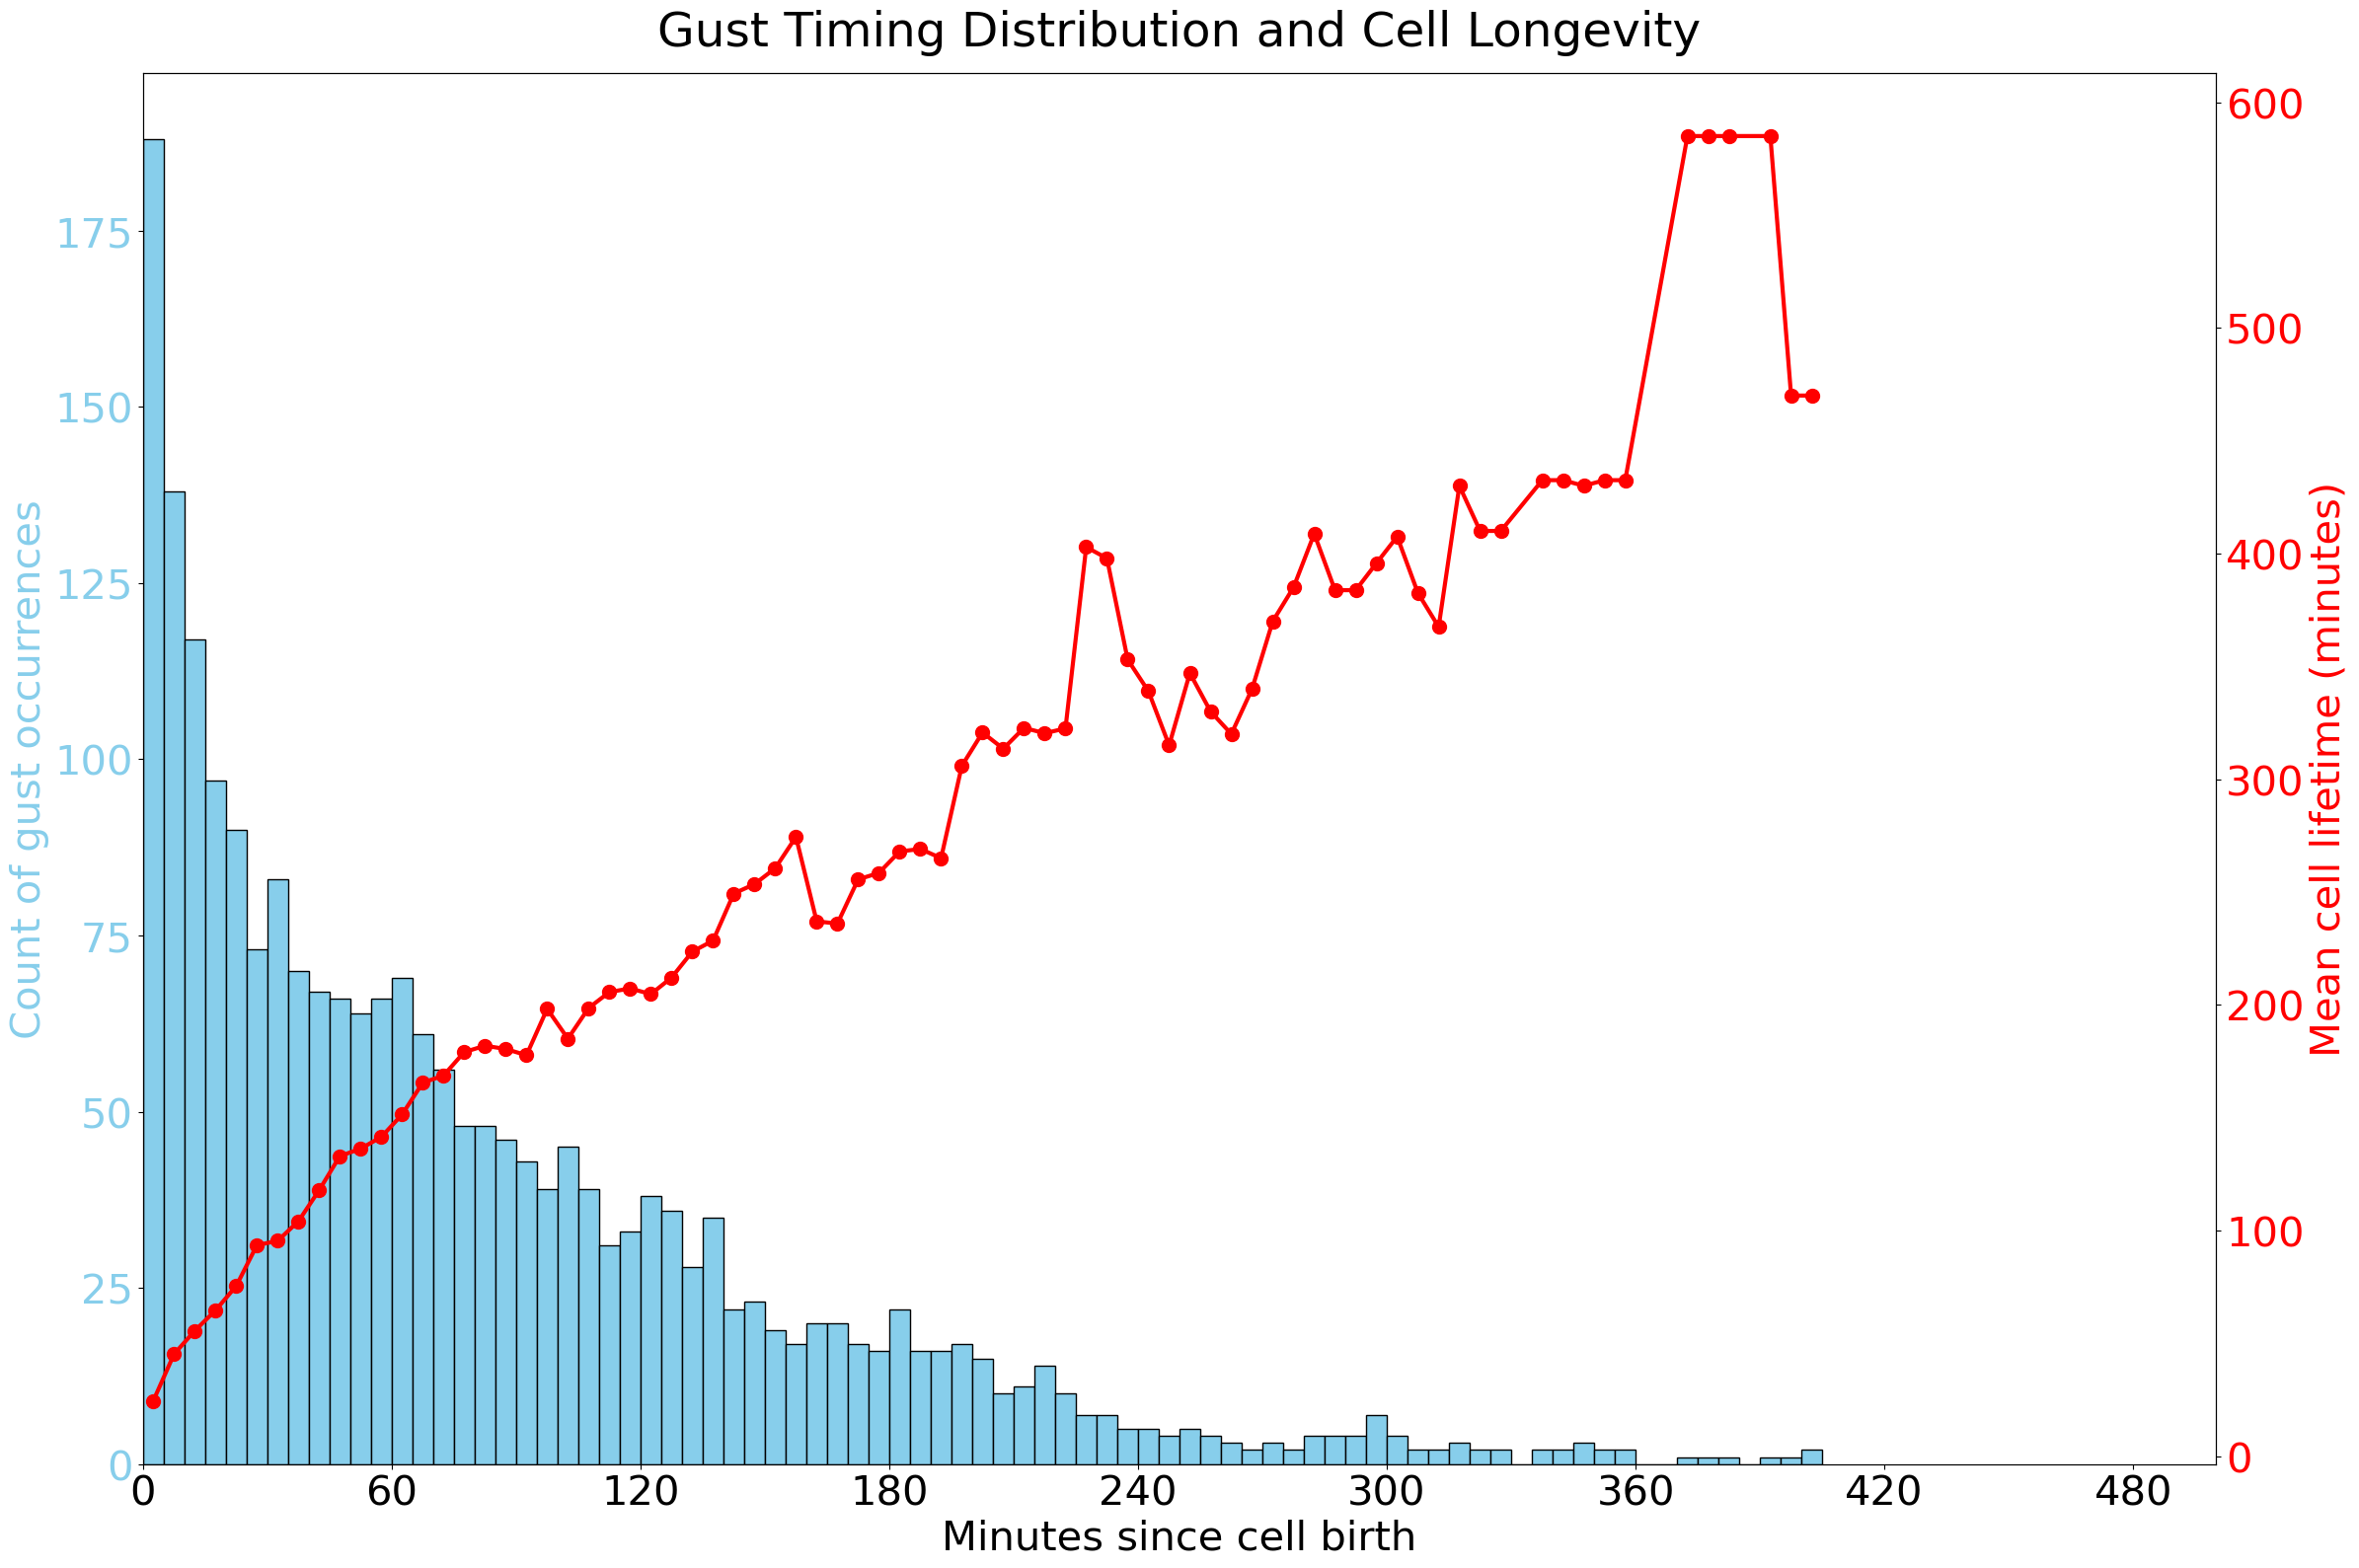

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to include only rows where 'Gust_Flag' == 'Yes'
gust_subset = merged_df[merged_df['Gust_Flag'] == 'Yes']

# Extract datetime part from traj_ID and convert to datetime
gust_subset['cell_birth'] = pd.to_datetime(gust_subset['traj_ID'].astype(str).str[:12], format='%Y%m%d%H%M')

# Calculate time difference in minutes
gust_subset['time_since_birth'] = (gust_subset['time'] - gust_subset['cell_birth']).dt.total_seconds() / 60

# Calculate cell lifetimes from the original dataset (merged_df)
cell_lifetimes = merged_df.groupby('traj_ID').size() * 5  # Each occurrence represents 5 minutes
cell_lifetimes = cell_lifetimes.reset_index(name='lifetime')  # Convert to DataFrame

# Create bins and calculate mean lifetimes
bin_edges = range(0, int(gust_subset['time_since_birth'].max()) + 5, 5)
mean_lifetimes = []
bin_centers = []

for i in range(len(bin_edges) - 1):
    # Get all cells active in this time window
    lower = bin_edges[i]
    upper = bin_edges[i + 1]
    mask = (gust_subset['time_since_birth'] >= lower) & (gust_subset['time_since_birth'] < upper)
    cells_in_bin = gust_subset.loc[mask, 'traj_ID'].unique()
    
    # Calculate mean lifetime for these cells using the original dataset
    if len(cells_in_bin) > 0:
        mean_lifetime = cell_lifetimes[cell_lifetimes['traj_ID'].isin(cells_in_bin)]['lifetime'].mean()
        mean_lifetimes.append(mean_lifetime)
        bin_centers.append((lower + upper) / 2)

# Create plot
fig, ax1 = plt.subplots(figsize=(24, 16))

# Main histogram
ax1.hist(gust_subset['time_since_birth'], bins=bin_edges, 
         color='skyblue', edgecolor='black')
ax1.set_xlabel('Minutes since cell birth', fontsize=30)
ax1.set_ylabel('Count of gust occurrences', color='skyblue', fontsize=30)
ax1.tick_params(axis='y', labelcolor='skyblue', labelsize=30)
ax1.set_xlim(0, 500)
ax1.set_xticks(range(0, 501, 60))
ax1.tick_params(axis='x', labelsize=30)

# Add second axis for mean lifetimes
ax2 = ax1.twinx()
if mean_lifetimes:  # Only plot if there are non-empty bins
    ax2.plot(bin_centers, mean_lifetimes, color='red', marker='o', linewidth=3, markersize=10)
ax2.set_ylabel('Mean cell lifetime (minutes)', color='red', fontsize=30)
ax2.tick_params(axis='y', labelcolor='red', labelsize=30)

plt.title('Gust Timing Distribution and Cell Longevity', fontsize=35, pad=20)
plt.tight_layout()


#plt.savefig("/users/fackerma/newproject1/figures/Ground_Truth/Lifecycle_hist_reworked1.png", bbox_inches='tight', dpi=300)



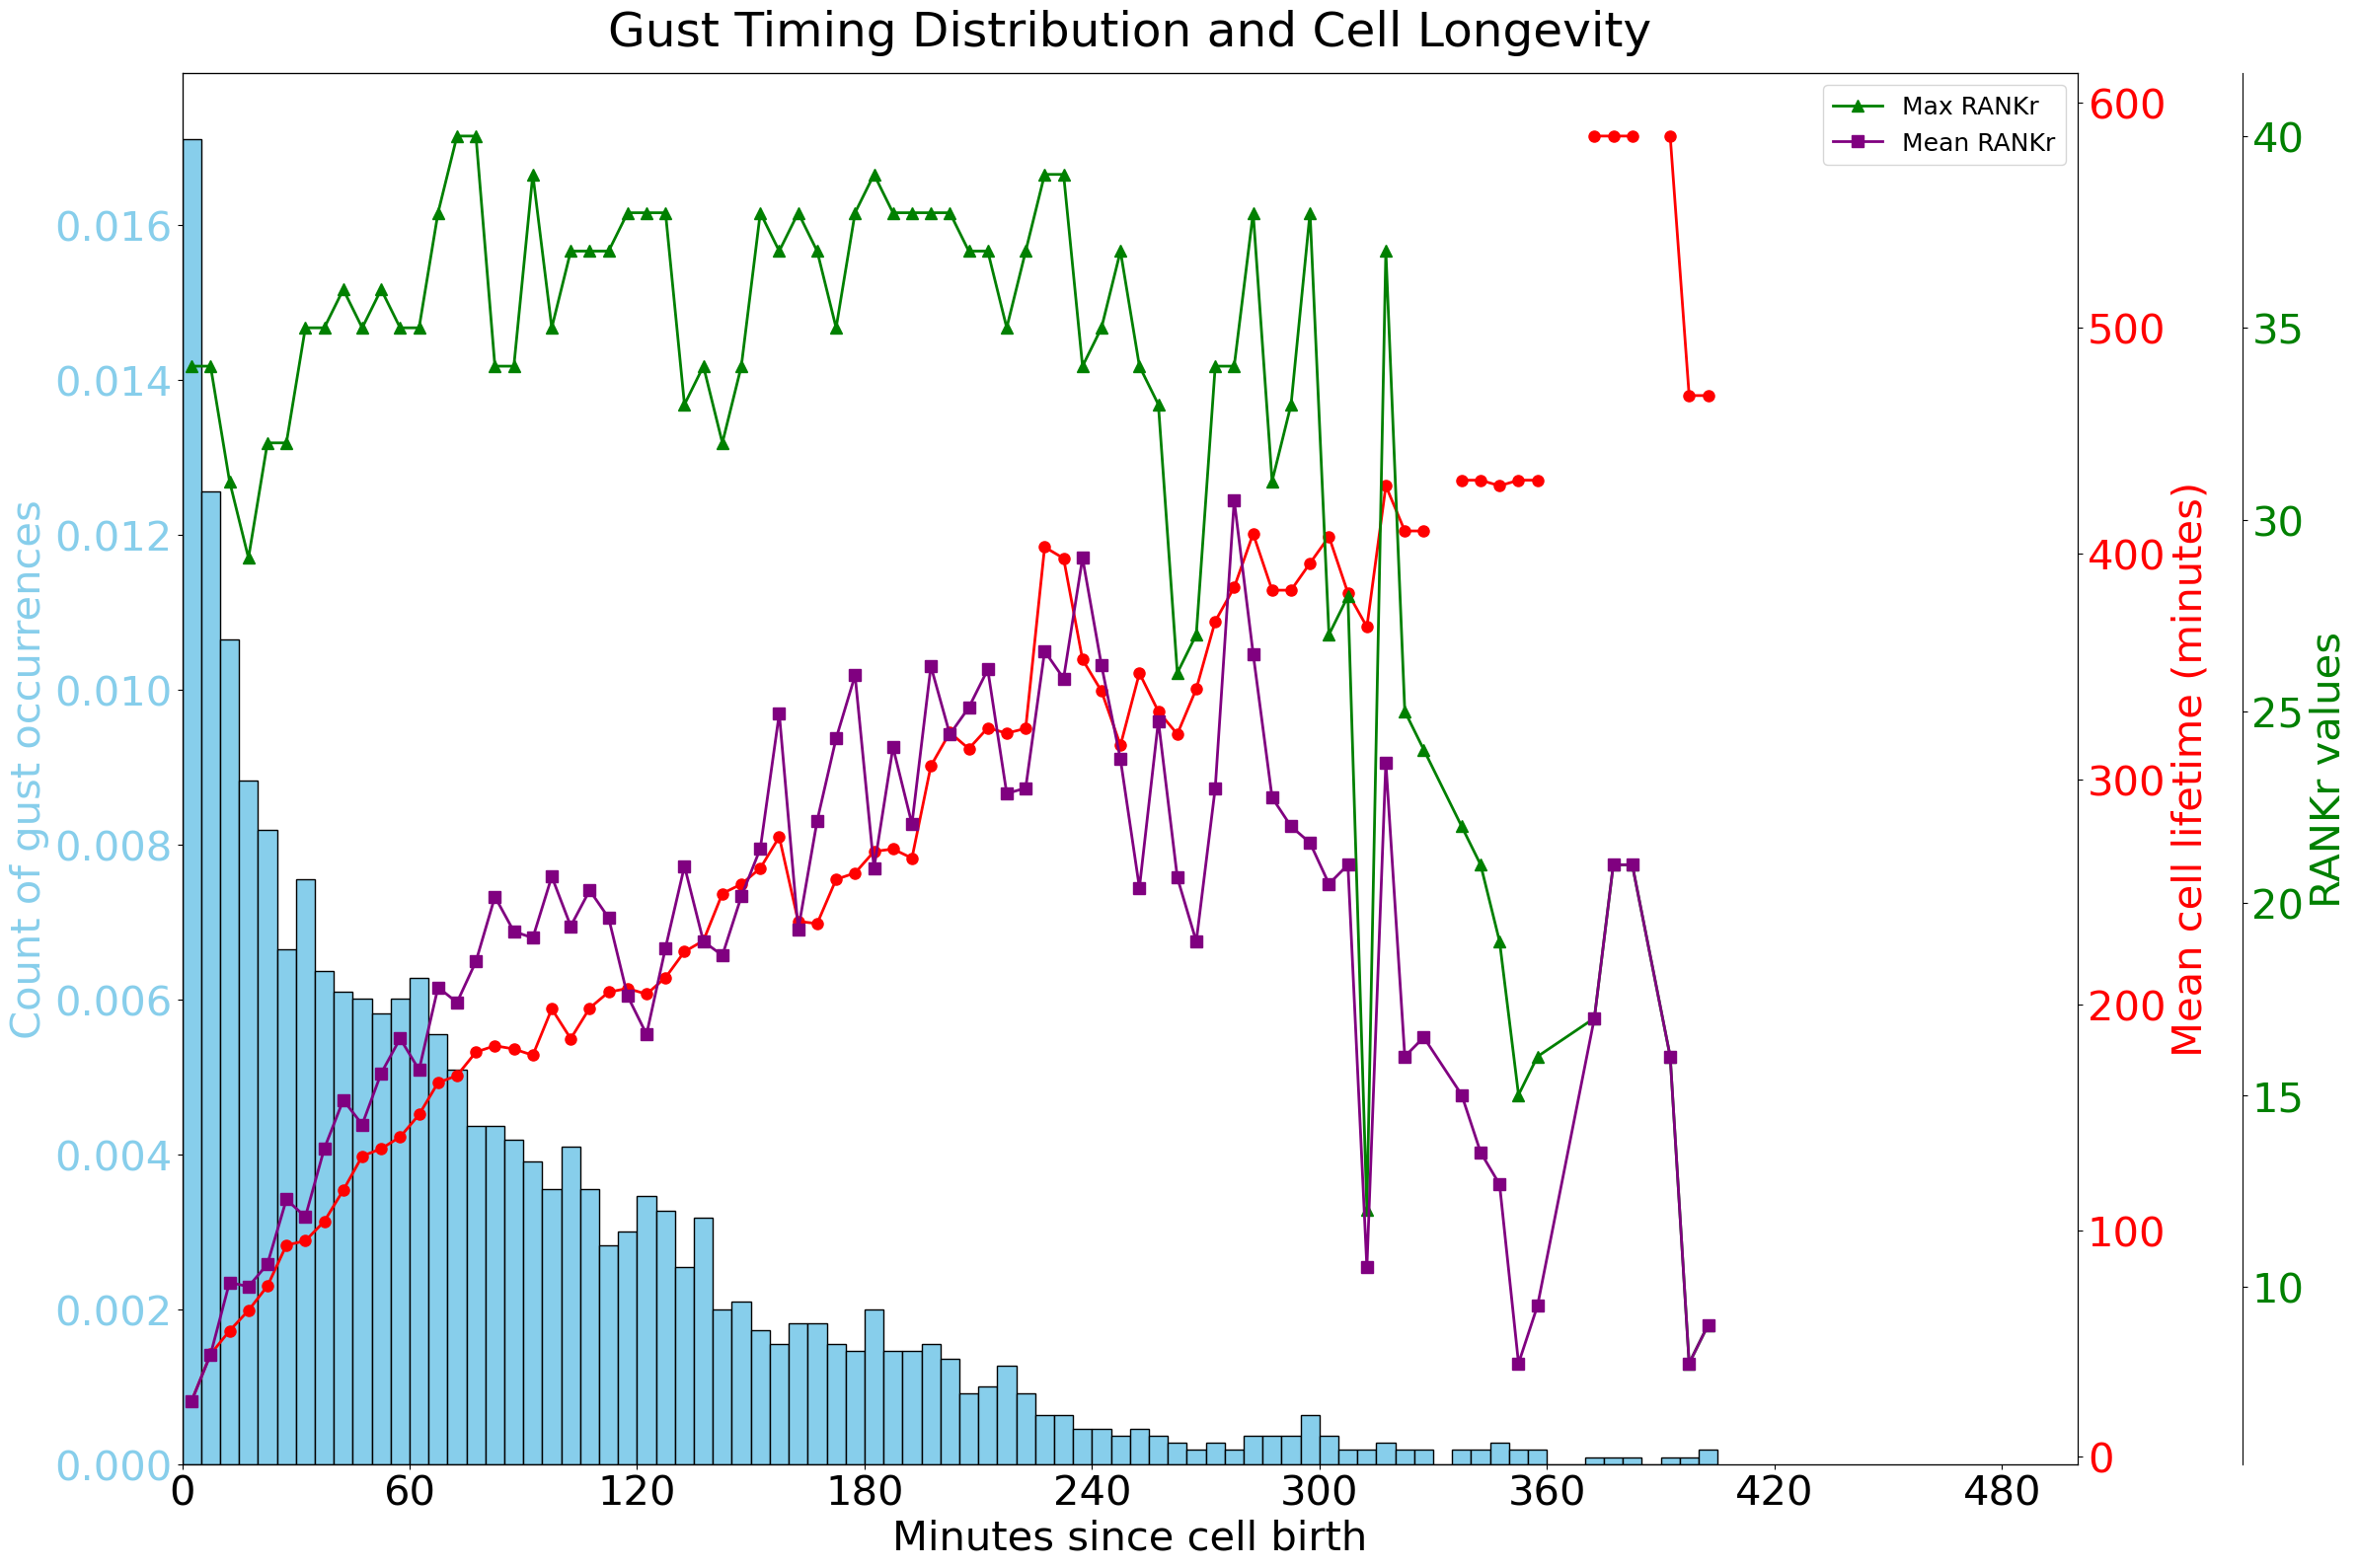

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter gusts
gust_subset = merged_df[merged_df['Gust_Flag'] == 'Yes'].copy()

# Extract cell birth datetime from traj_ID
gust_subset['cell_birth'] = pd.to_datetime(gust_subset['traj_ID'].astype(str).str[:12], format='%Y%m%d%H%M')

# Time since cell birth in minutes
gust_subset['time_since_birth'] = (gust_subset['time'] - gust_subset['cell_birth']).dt.total_seconds() / 60

# IMPORTANT: Convert RANKr to numeric type - this fixes the error
gust_subset['RANKr'] = pd.to_numeric(gust_subset['RANKr'], errors='coerce')

# Compute cell lifetimes (in minutes)
cell_lifetimes = merged_df.groupby('traj_ID').size() * 5
cell_lifetimes = cell_lifetimes.reset_index(name='lifetime')

# Binning setup
bin_edges = np.arange(0, gust_subset['time_since_birth'].max() + 5, 5)
mean_lifetimes = []
bin_centers = []
max_rankr = []
mean_rankr = []

for i in range(len(bin_edges) - 1):
    lower = bin_edges[i]
    upper = bin_edges[i + 1]
    mask = (gust_subset['time_since_birth'] >= lower) & (gust_subset['time_since_birth'] < upper)
    cells_in_bin = gust_subset.loc[mask, 'traj_ID'].unique()

    # Mean cell lifetime
    if len(cells_in_bin) > 0:
        mean_lifetime = cell_lifetimes[cell_lifetimes['traj_ID'].isin(cells_in_bin)]['lifetime'].mean()
        mean_lifetimes.append(mean_lifetime)
        bin_centers.append((lower + upper) / 2)
        
        # RANKr stats
        bin_rankr = gust_subset.loc[mask, 'RANKr']
        max_rankr.append(bin_rankr.max())
        mean_rankr.append(bin_rankr.mean())
    else:
        mean_lifetimes.append(np.nan)
        bin_centers.append((lower + upper) / 2)
        max_rankr.append(np.nan)
        mean_rankr.append(np.nan)



# Plotting
fig, ax1 = plt.subplots(figsize=(24, 16))

# Histogram
ax1.hist(gust_subset['time_since_birth'], bins=bin_edges, color='skyblue', edgecolor='black', density=True)
ax1.set_xlabel('Minutes since cell birth', fontsize=30)
ax1.set_ylabel('Count of gust occurrences', color='skyblue', fontsize=30)
ax1.tick_params(axis='y', labelcolor='skyblue', labelsize=30)
ax1.set_xlim(0, 500)
ax1.set_xticks(range(0, 501, 60))
ax1.tick_params(axis='x', labelsize=30)

# Second axis: mean lifetime
ax2 = ax1.twinx()
ax2.plot(bin_centers, mean_lifetimes, color='red', marker='o', linewidth=2, markersize=8, label='Mean lifetime')
ax2.set_ylabel('Mean cell lifetime (minutes)', color='red', fontsize=30)
ax2.tick_params(axis='y', labelcolor='red', labelsize=30)

# Third axis: RANKr
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 120))

# Convert to numpy arrays for masking
bin_centers_arr = np.array(bin_centers)
max_rankr_arr = np.array(max_rankr)
mean_rankr_arr = np.array(mean_rankr)

# Mask: bins where max_rankr is not nan
valid_mask = ~np.isnan(max_rankr_arr)

# Plot only non-empty bins for RANKr statistics
ax3.plot(bin_centers_arr[valid_mask], max_rankr_arr[valid_mask], color='green', marker='^', linewidth=2, markersize=8, label='Max RANKr')
ax3.plot(bin_centers_arr[valid_mask], mean_rankr_arr[valid_mask], color='purple', marker='s', linewidth=2, markersize=8, label='Mean RANKr')

ax3.set_ylabel('RANKr values', color='green', fontsize=30)
ax3.tick_params(axis='y', labelcolor='green', labelsize=30)

# Legends
lines1, labels1 = ax3.get_legend_handles_labels()
ax3.legend(lines1, labels1, loc='upper right', fontsize=18)

plt.title('Gust Timing Distribution and Cell Longevity', fontsize=35, pad=20)
plt.tight_layout()



#plt.savefig("/users/fackerma/newproject1/figures/Ground_Truth/Lifecycle_hist_reworked.png", bbox_inches='tight', dpi=300)




In [46]:
import pandas as pd

# Define the file path
file_path = "/scratch/mch/fackerma/orders/TRT_processing_2/TRT_2023_05-10.pkl"

# Load the pickle file into a DataFrame
df = pd.read_pickle(file_path)

# Print all column names and the first 10 rows of each column
print("First 10 Rows of Each Column:\n")
for column in df.columns:
    print(f"Column: {column}")
    print(df[column].head(10))  # Display the first 10 rows of the column
    print("\n" + "-" * 50 + "\n")  # Separator for readability


First 10 Rows of Each Column:

Column: timestamp
0   2023-05-01 00:00:00
1   2023-05-01 00:00:00
2   2023-05-01 00:05:00
3   2023-05-01 00:05:00
4   2023-05-01 01:10:00
5   2023-05-01 01:15:00
6   2023-05-01 01:30:00
7   2023-05-01 01:35:00
8   2023-05-01 02:10:00
9   2023-05-01 02:15:00
Name: timestamp, dtype: datetime64[us]

--------------------------------------------------

Column: geometry
0    POLYGON ((7.2172 44.8956, 7.192 44.8775, 7.192...
1    POLYGON ((7.3566 44.7519, 7.3566 44.7429, 7.34...
2    POLYGON ((7.2172 44.8956, 7.2046 44.8865, 7.20...
3    POLYGON ((7.3187 44.7608, 7.3188 44.7428, 7.30...
4    POLYGON ((7.4195 45.3454, 7.4068 45.3364, 7.40...
5    POLYGON ((7.4195 45.3454, 7.4068 45.3364, 7.40...
6    POLYGON ((8.8822 46.1637, 8.8559 46.1461, 8.84...
7    POLYGON ((8.8714 46.2449, 8.8707 46.2179, 8.89...
8    POLYGON ((8.5427 44.099, 8.5422 44.0721, 8.579...
9    POLYGON ((8.1025 46.9896, 8.1023 46.9716, 8.08...
Name: geometry, dtype: geometry

-------------------

## Mesocyclone

In [50]:
import pandas as pd

# File paths
base_path = "/scratch/mch/fackerma/orders/Mesocyclone/"
files = [
    "TRT_mesostorm1.txt",
    "TRT_mesostorm_2022.txt",
    "TRT_mesostorm_2023cor.txt"
]

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file, load it, and select relevant columns
for file_name in files:
    file_path = base_path + file_name
    try:
        # Load the file into a DataFrame with semicolon separator
        df = pd.read_csv(file_path, sep=";")
        
        # Select only the required columns
        selected_columns = ['ID', 'time', 'pos', 'neg']
        df_selected = df[selected_columns]
        
        # Append the selected DataFrame to the list
        dataframes.append(df_selected)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Assuming combined_df is already created
# Remove the '.0' suffix by converting to integer first, then to string
combined_df['time'] = pd.to_datetime(combined_df['time'].astype(int).astype(str), format='%Y%m%d%H%M')

# Rename 'ID' column to 'traj_ID'
combined_df.rename(columns={'ID': 'traj_ID'}, inplace=True)

# Keep only the first 16 characters of traj_ID
combined_df['traj_ID'] = combined_df['traj_ID'].astype(str).str[:16]  # <-- Add this line

combined_df['traj_ID'] = combined_df['traj_ID'].astype('object')
combined_df['timestamp'] = combined_df['time'].astype('datetime64[us]')

# Define the start and end dates for filtering
start_date = "2019-05-01"
end_date = "2023-10-31"

# Filter rows based on the date range
combined_df = combined_df[
    (combined_df['timestamp'] >= pd.to_datetime(start_date)) &
    (combined_df['timestamp'] <= pd.to_datetime(end_date)) &
    (combined_df['timestamp'].dt.month >= 5) & 
    (combined_df['timestamp'].dt.month <= 10)
]

merged_df['timestamp'] = pd.to_datetime(merged_df['yyyymmddHHMM'], format='%Y%m%d%H%M')
merged_df['timestamp'] = merged_df['timestamp'].astype('datetime64[us]')




# Add this line before merging
merged_df['traj_ID'] = merged_df['traj_ID'].astype(str).str[:16]  # <-- Add this line

# Merge 'pos' and 'neg' from combined_df into merged_df
#merged_df = merged_df.merge(
    #combined_df[['traj_ID', 'timestamp', 'pos', 'neg']],
    #on=['traj_ID', 'timestamp'],
    #how='left'
#)

#Step 1: Perform a full outer merge on 'timestamp' and 'traj_ID'
mesocyclone_df = pd.merge(
    merged_df,
    combined_df[['traj_ID', 'timestamp', 'pos', 'neg']],  # Select relevant columns from combined_df
    on=['timestamp', 'traj_ID'],
    how='outer'
)



# Replace NaN values in 'pos' and 'neg' columns with 0.0
mesocyclone_df[['pos', 'neg']] = mesocyclone_df[['pos', 'neg']].fillna(0.0)



In [42]:
print(combined_df['traj_ID'].dtype)
print(merged_df['traj_ID'].dtype)
print(combined_df['timestamp'].dtype)
print(merged_df['timestamp'].dtype)

object
object
datetime64[us]
datetime64[us]


In [43]:
print(combined_df['traj_ID'].head)
print(merged_df['traj_ID'].head)
print(combined_df['timestamp'].head)
print(merged_df['timestamp'].head)

<bound method NDFrame.head of 8828     2019051114250014
8829     2019051114250014
8830     2019051114250014
8831     2019051114250014
8832     2019051114250014
               ...       
24668    2023092221250012
24669    2023092221250012
24670    2023092221250012
24671    2023092221250012
24672    2023092221250012
Name: traj_ID, Length: 15845, dtype: object>
<bound method NDFrame.head of 0          2019050109550001
1          2019050109550001
2          2019050110050002
3          2019050109550001
4          2019050110050002
                 ...       
2240261    2023103116250002
2240262    2023103116250002
2240263    2023103116300005
2240264    2023103117200001
2240265    2023103117450002
Name: traj_ID, Length: 2240266, dtype: object>
<bound method NDFrame.head of 8828    2019-05-11 14:25:00
8829    2019-05-11 14:30:00
8830    2019-05-11 14:35:00
8831    2019-05-11 14:40:00
8832    2019-05-11 14:45:00
                ...        
24668   2023-09-23 00:50:00
24669   2023-09-23 00:55:00


In [34]:
merged_df.columns

for col in merged_df.columns:
                dtype = merged_df[col].dtype
                non_null = merged_df[col].count()
                null_percentage = (1 - non_null / len(merged_df)) * 100
                print(f"  {col}: {dtype}, {non_null} non-null values ({null_percentage:.2f}% null)")

  geometry: geometry, 2240266 non-null values (0.00% null)
  Age: float64, 2240266 non-null values (0.00% null)
  CS Marker: object, 2240266 non-null values (0.00% null)
  STA Marker: object, 2240266 non-null values (0.00% null)
  ESWD Marker: object, 2240266 non-null values (0.00% null)
  STA Speed: object, 745 non-null values (99.97% null)
  Gust_Flag: object, 2240266 non-null values (0.00% null)
  time: datetime64[us], 2240266 non-null values (0.00% null)
  traj_ID: object, 2240266 non-null values (0.00% null)
  yyyymmddHHMM: object, 2240266 non-null values (0.00% null)
  lon: object, 2240266 non-null values (0.00% null)
  lat: object, 2240266 non-null values (0.00% null)
  ell_L: object, 2240266 non-null values (0.00% null)
  ell_S: object, 2240266 non-null values (0.00% null)
  ell_or: object, 2240266 non-null values (0.00% null)
  area: object, 2240266 non-null values (0.00% null)
  vel_x: object, 2223198 non-null values (0.76% null)
  vel_y: object, 2223198 non-null values (0.76

In [11]:
print("combined_df column dtypes:")
print(combined_df.dtypes)
print("\nmerged_df column dtypes:")
print(merged_df.dtypes)


combined_df column dtypes:
traj_ID              object
time         datetime64[ns]
pos                 float64
neg                 float64
timestamp    datetime64[us]
dtype: object

merged_df column dtypes:
geometry             geometry
Age                   float64
CS Marker              object
STA Marker             object
ESWD Marker            object
                    ...      
nrPOHthr070            object
nrPOHthr080            object
nrPOHthr090            object
nrPOHthr100            object
timestamp      datetime64[us]
Length: 93, dtype: object


In [45]:
merged_df['traj_ID'].dtype

dtype('O')

In [46]:
# Merge with indicator
comparison = merged_df.merge(
    combined_df[['timestamp', 'traj_ID']],
    on=['timestamp', 'traj_ID'],
    how='left',
    indicator=True
)

# Rows only in merged_df
not_in_mesocyclone = comparison[comparison['_merge'] == 'left_only']
print(not_in_mesocyclone[['timestamp', 'traj_ID']])


                  timestamp           traj_ID
0       2019-05-01 09:55:00  2019050109550001
1       2019-05-01 10:00:00  2019050109550001
2       2019-05-01 10:05:00  2019050110050002
3       2019-05-01 10:05:00  2019050109550001
4       2019-05-01 10:10:00  2019050110050002
...                     ...               ...
2240261 2023-10-31 16:25:00  2023103116250002
2240262 2023-10-31 16:30:00  2023103116250002
2240263 2023-10-31 16:30:00  2023103116300005
2240264 2023-10-31 17:20:00  2023103117200001
2240265 2023-10-31 17:45:00  2023103117450002

[2224946 rows x 2 columns]


In [47]:
# Merge with indicator
comparison2 = combined_df[['timestamp', 'traj_ID']].merge(
    merged_df[['timestamp', 'traj_ID']],
    on=['timestamp', 'traj_ID'],
    how='left',
    indicator=True
)

# Rows only in mesocyclone_df
not_in_merged = comparison2[comparison2['_merge'] == 'left_only']
print(not_in_merged[['timestamp', 'traj_ID']])


                timestamp           traj_ID
10521 2022-05-23 11:00:00  2022052311000060
10522 2022-05-23 11:05:00  2022052311000060
10523 2022-05-23 11:10:00  2022052311000060
10524 2022-05-23 11:15:00  2022052311000060
10525 2022-05-23 11:20:00  2022052311000060
...                   ...               ...
11873 2022-09-07 22:20:00  2022090716350292
11874 2022-09-07 22:25:00  2022090716350292
11875 2022-09-07 22:30:00  2022090716350292
11876 2022-09-07 22:35:00  2022090716350292
11877 2022-09-07 22:40:00  2022090716350292

[525 rows x 2 columns]


In [48]:
combination_counts = merged_df[merged_df['Gust_Flag'].notna()].groupby(['Gust_Flag', 'pos', 'neg']).size().reset_index(name='Count')
combination_counts

KeyError: 'pos'

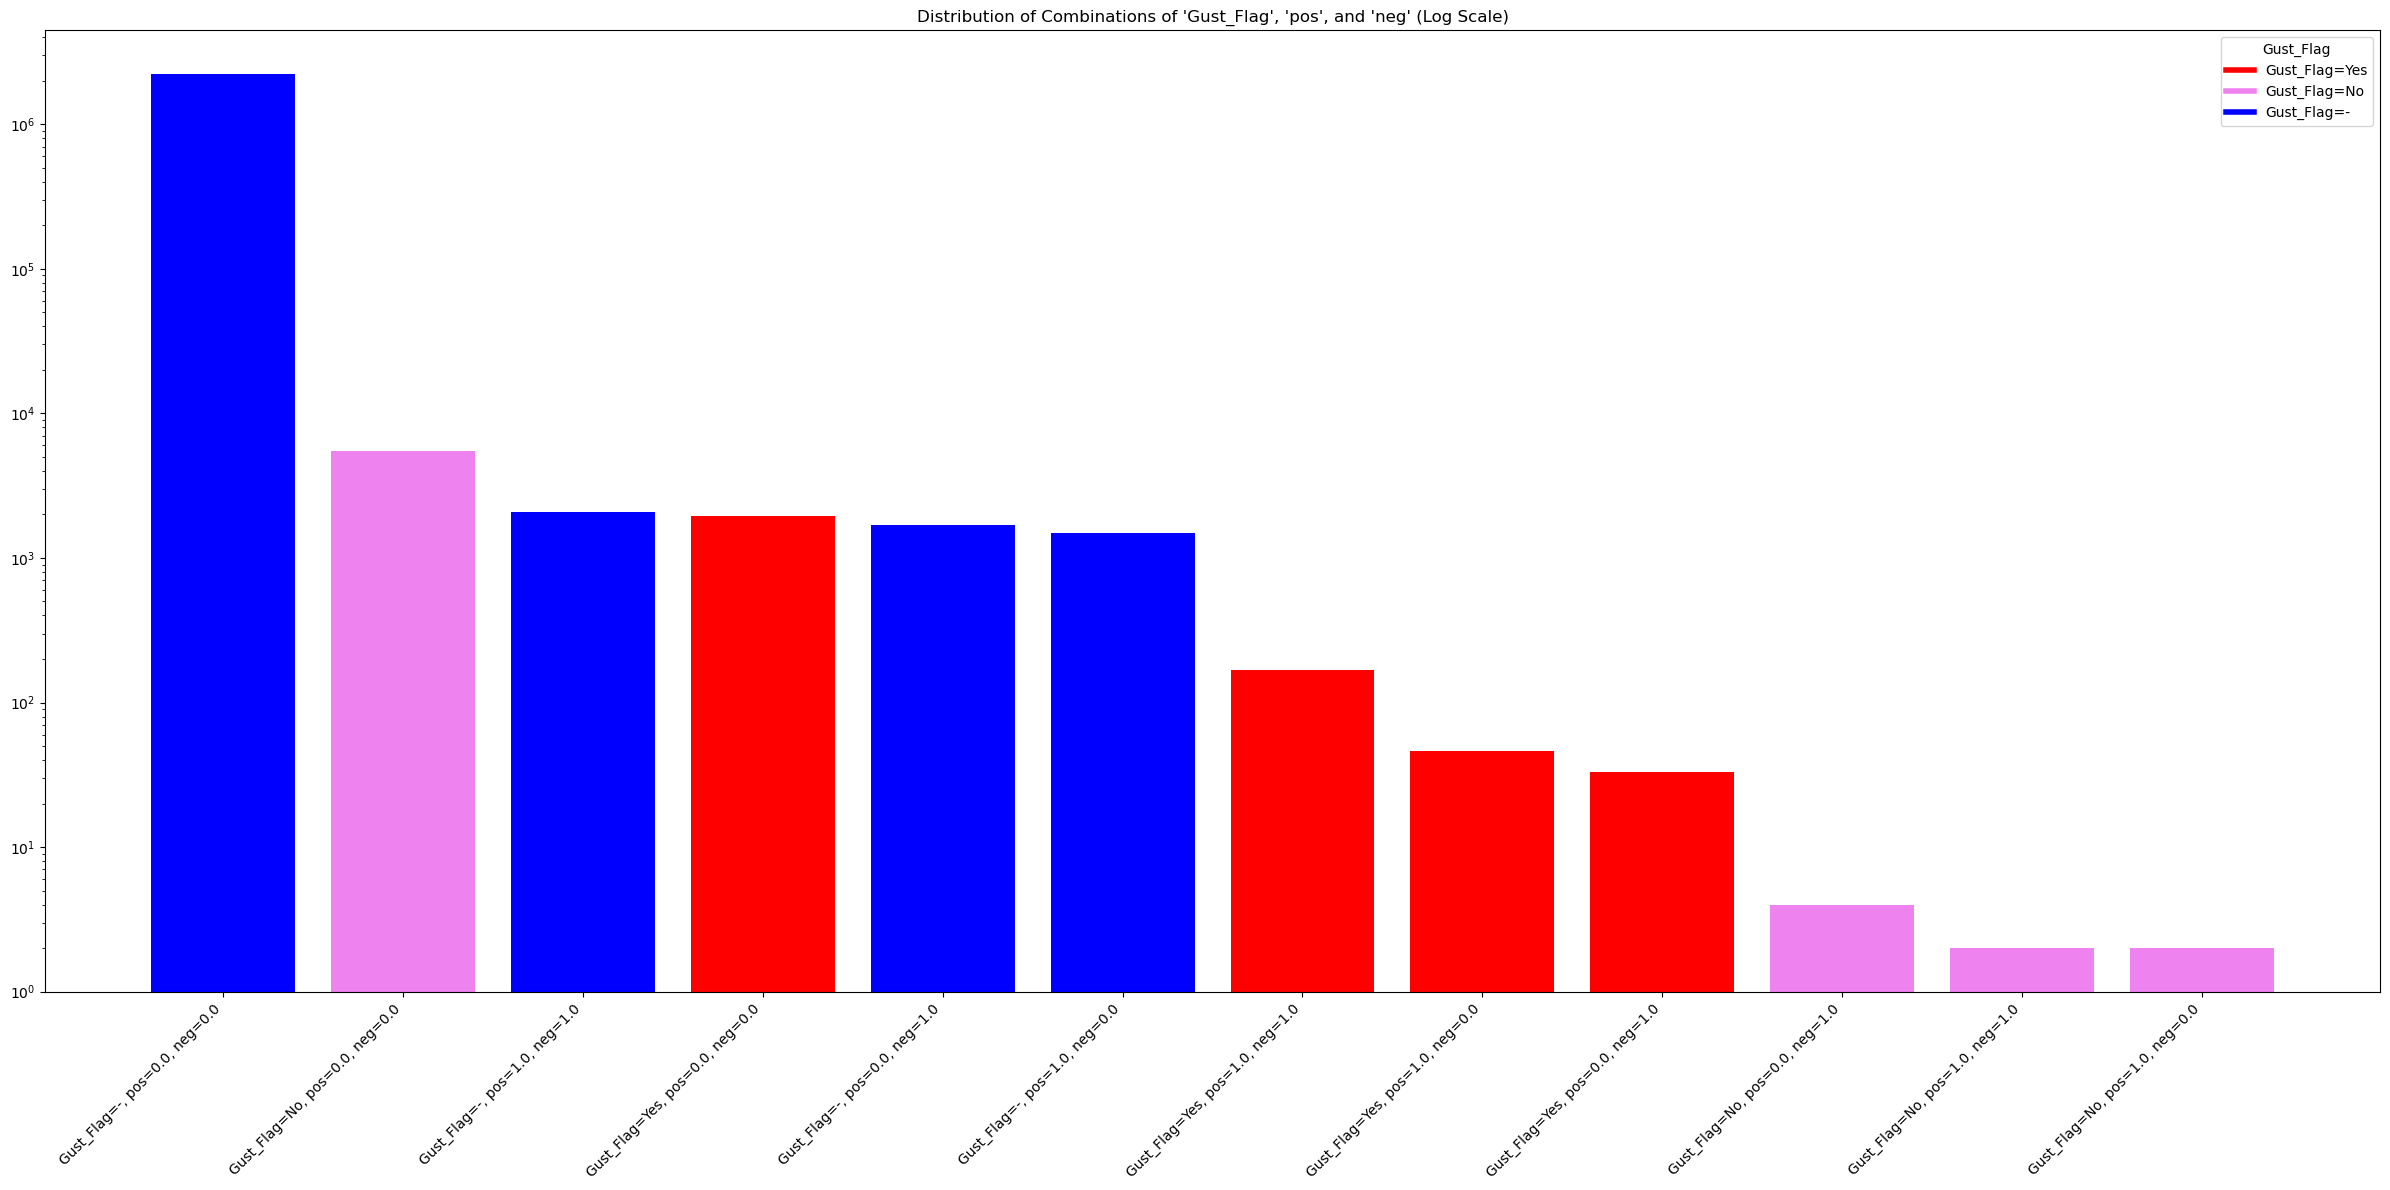

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by 'Gust_Flag', 'pos', and 'neg' and count occurrences
combination_counts = mesocyclone_df.groupby(['Gust_Flag', 'pos', 'neg']).size().reset_index(name='Count')

# Create a new column to represent the combination as a string for better visualization
combination_counts['Combination'] = (
    "Gust_Flag=" + combination_counts['Gust_Flag'].astype(str) +
    ", pos=" + combination_counts['pos'].astype(str) +
    ", neg=" + combination_counts['neg'].astype(str)
)

# Sort by count for better visualization
combination_counts = combination_counts.sort_values(by='Count', ascending=False)

# Define colors for each 'Gust_Flag' category
gust_flag_colors = {'Yes': 'red', 'No': 'violet', '-': 'blue'}
bar_colors = combination_counts['Gust_Flag'].map(gust_flag_colors)

# Plot the distribution as a bar chart with a logarithmic scale
plt.figure(figsize=(24, 12))
plt.bar(
    combination_counts['Combination'], 
    combination_counts['Count'], 
    color=bar_colors
)
plt.title("Distribution of Combinations of 'Gust_Flag', 'pos', and 'neg' (Log Scale)")
plt.xlabel("")
plt.ylabel("")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=45, ha='right')
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=4, label='Gust_Flag=Yes'),
    plt.Line2D([0], [0], color='violet', lw=4, label='Gust_Flag=No'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Gust_Flag=-')
], title="Gust_Flag")
plt.tight_layout()


#plt.savefig("/users/fackerma/newproject1/figures/Ground_Truth/Mesocyclone_logscale_reworked.png")

## Features

In [1]:
## Import the datafile containing the features
import pickle

# Specify the path to your .pkl file
file_path = "/scratch/mch/fackerma/orders/TRT_modelsetup_3/Model_Setup_3.pkl"

with open(file_path, 'rb') as file:
        data = pickle.load(file)

In [6]:
data.columns

Index(['timestamp', 'geometry', 'CS Marker', 'STA Marker', 'ESWD Marker',
       'Gust_Flag', 'traj_ID', 'time', 'lon', 'lat',
       ...
       'ZH_percent_above_55', 'KDP_com_height', 'KDP_percent_above_2',
       'KDP_percent_above_1.5', 'KDP_percent_above_1', 'rad_shear_max',
       'rad_shear_percent_above_2.5', 'rad_shear_percent_above_2',
       'rad_shear_percent_above_1.5', 'area_p'],
      dtype='object', length=104)

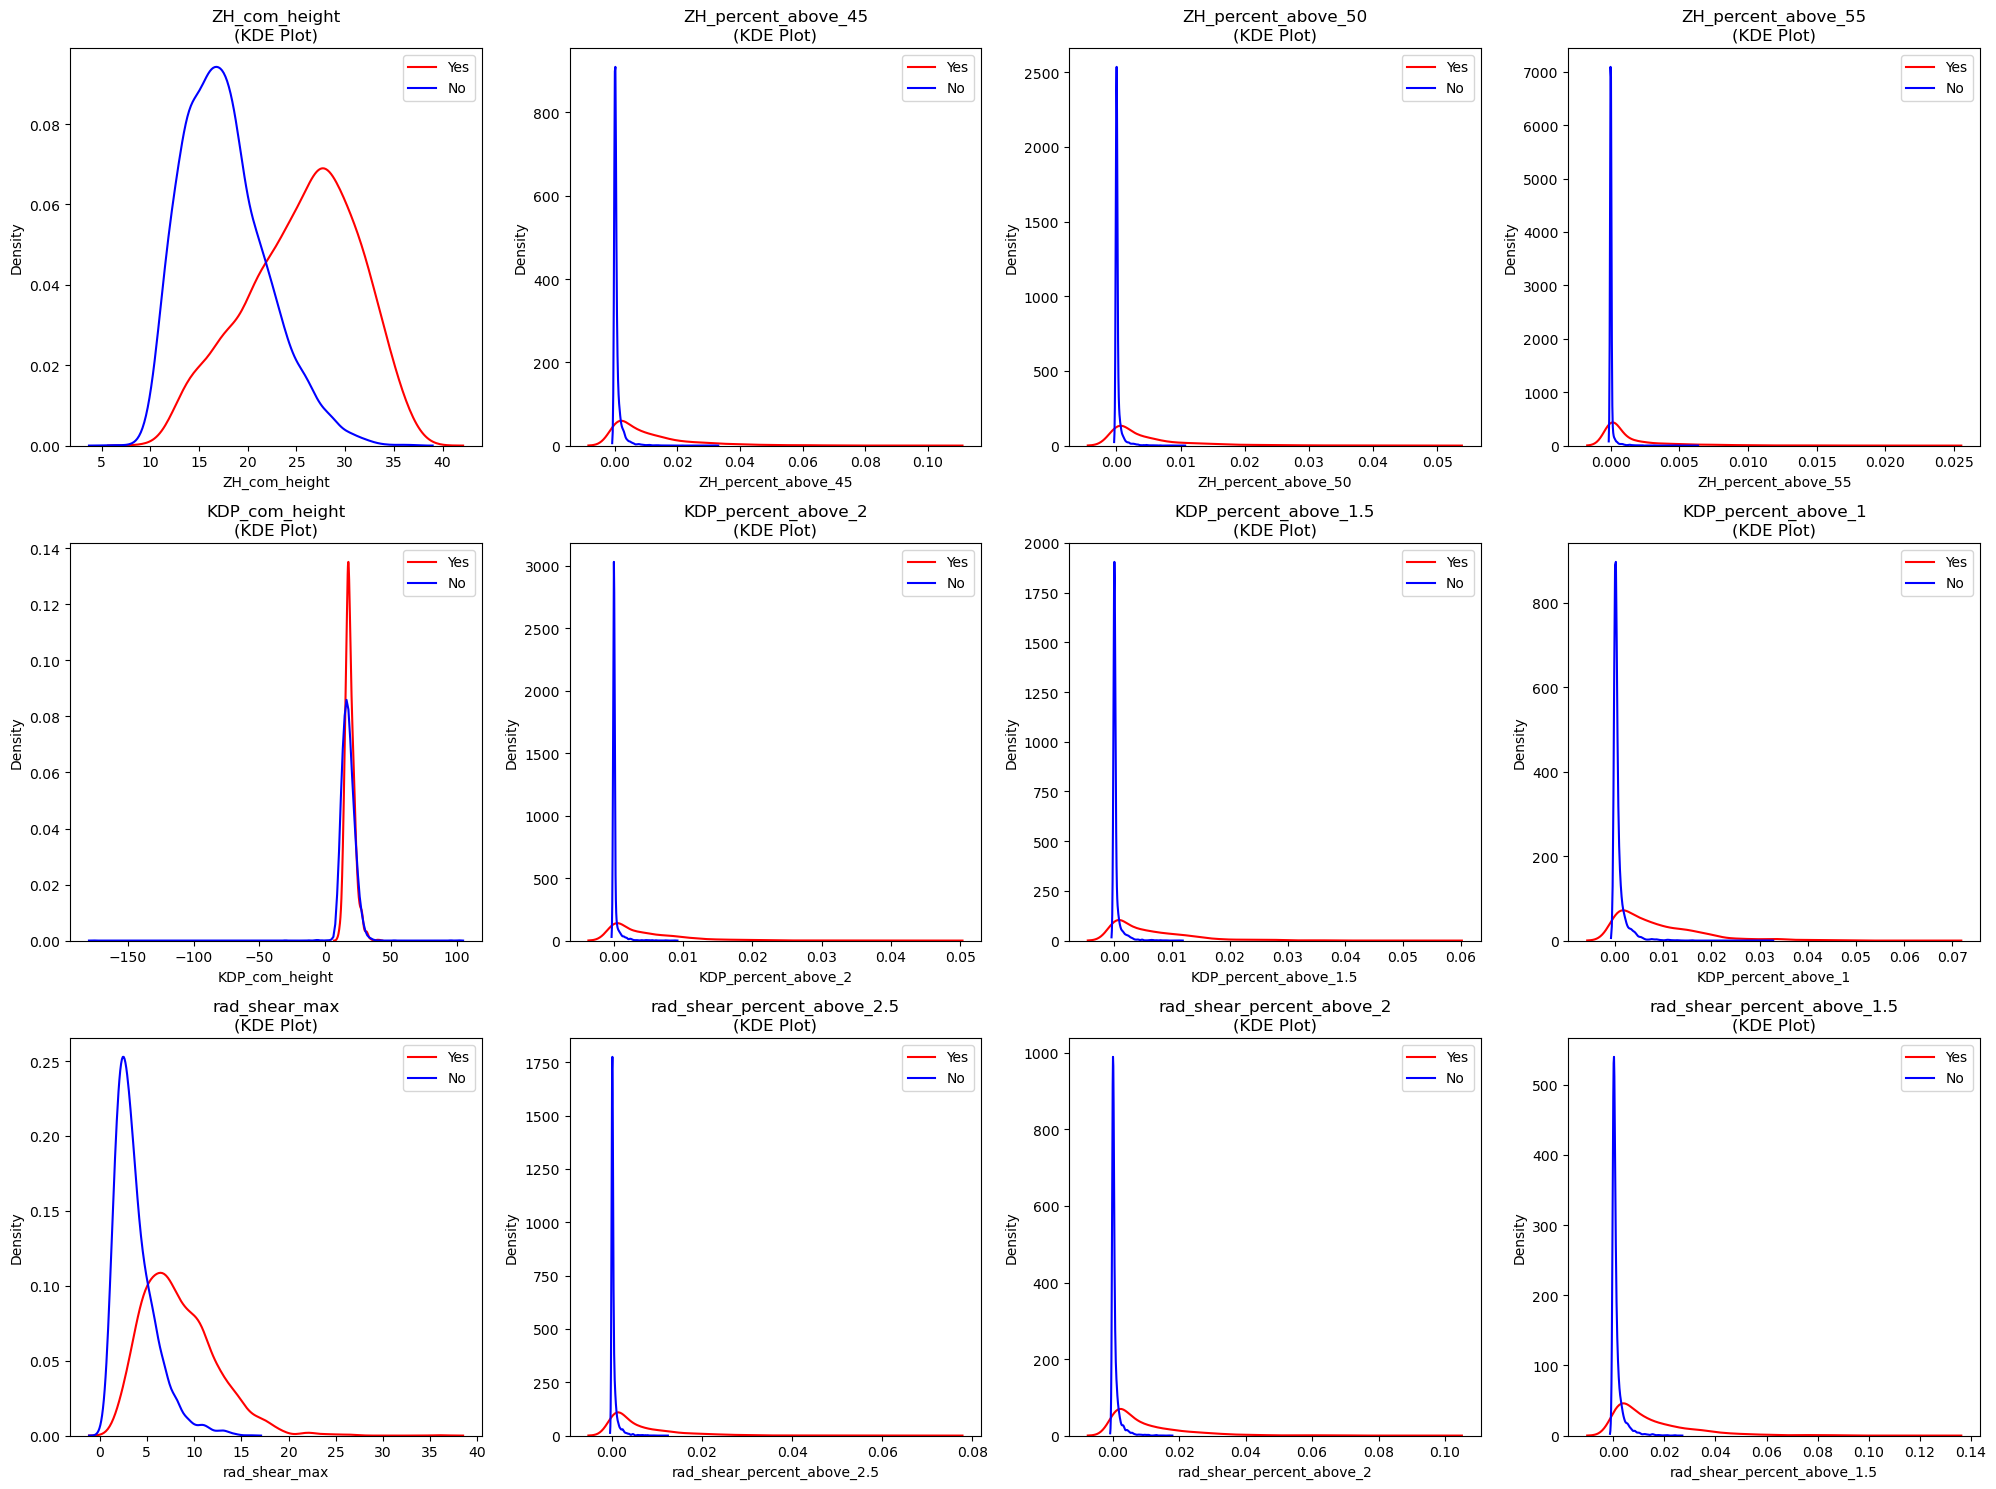

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data into groups
gust_yes = data[data['Gust_Flag'] == 'Yes']
gust_no = data[data['Gust_Flag'] == 'No']

# List of columns to analyze
columns = [
    'ZH_com_height', 'ZH_percent_above_45', 'ZH_percent_above_50', 'ZH_percent_above_55',
    'KDP_com_height', 'KDP_percent_above_2', 'KDP_percent_above_1.5', 'KDP_percent_above_1',
    'rad_shear_max', 'rad_shear_percent_above_2.5', 'rad_shear_percent_above_2',
    'rad_shear_percent_above_1.5'
]

# Create figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot distributions for each column
for i, col in enumerate(columns):
    try:
        sns.kdeplot(gust_yes[col], color='red', label='Yes', ax=axes[i])
        sns.kdeplot(gust_no[col], color='blue', label='No', ax=axes[i])
        axes[i].set_title(f'{col}\n(KDE Plot)')
        axes[i].legend()
    except KeyError:
        print(f"Column {col} not found in DataFrame")
        continue

plt.tight_layout()
#plt.savefig('/users/fackerma/newproject1/figures/feature_density_reworked.png')
